In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [9]:
import janitor as jn
import yellowbrick.features as ybf
import yellowbrick.model_selection as ybm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.ensemble import *

In [3]:
df = pd.read_csv('../data/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def tweak_titanic(df):
    df = (
        df.drop(columns=["Name", "Ticket", "Cabin"])
            .pipe(pd.get_dummies, drop_first=True)
    )
    return df

def get_train_test_X_y(df, target, size=0.3, std_cols=None):
    X, y = df.get_features_targets(target_columns=target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns
    num_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
    
    imp = IterativeImputer()
    fitted = imp.fit_transform(X_train[num_cols])
    
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = imp.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    
    if std_cols:
        std = StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "Pclass,Age,SibSp,Fare".split(",")

target = "Survived"

X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, target, std_cols=std_cols)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Validation Curve

C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


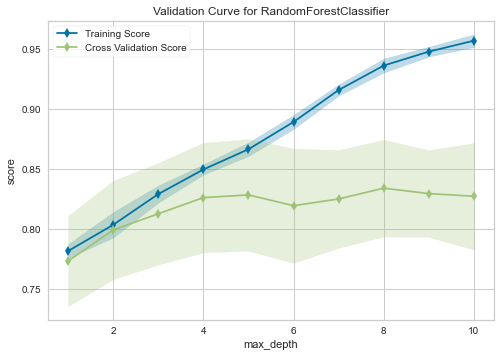

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [10]:
rfc = RandomForestClassifier(n_estimators=100)

vc_viz = ybm.ValidationCurve(
    rfc,
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    n_jobs=-1
)

vc_viz.fit(X, y)
vc_viz.poof()

## Learning Curve

C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


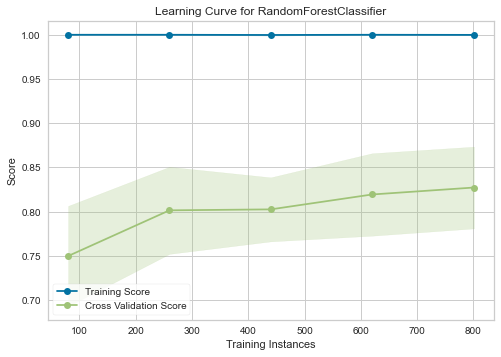

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [12]:
rfc = RandomForestClassifier(n_estimators=100)

lc3_viz = ybm.LearningCurve(rfc, cv=10)

lc3_viz.fit(X, y)
lc3_viz.poof()